# Housekeeping

- PyTorch hates new Python
- Need some environment, try `conda`

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and GPU

In [3]:
torch.cuda.empty_cache()

In [4]:
# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


## load data

In [5]:
df_train = pd.read_csv('./assignment/train_data.csv')
df_test = pd.read_csv('./assignment/test_data.csv')
df_solution = pd.read_csv('assignment/solution.csv')

X_name_list = [col for col in df_train.columns if col not in ['ID', 'Y']]
X = df_train[X_name_list]
y = df_train['Y']
X_test = df_test[X_name_list]
y_test = df_solution['Y']

In [7]:
# First move the input tensors to GPU before creating datasets
X_tensor = torch.from_numpy(X.values.copy()).float().to(device)

y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create TensorDataset with GPU tensors
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size], 
                                          generator=torch.Generator().manual_seed(42))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

X_test_tensor = torch.tensor(X_test.values.copy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.copy(), dtype=torch.float32).unsqueeze(1).to(device)



In [8]:
!nvidia-smi


Tue Oct  7 16:18:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S-12Q                On  |   00000000:00:05.0 Off |                    0 |
| N/A   N/A    P0            N/A  /  N/A  |     480MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## model

In [9]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Create a new DNN instance and move it to GPU
my_gpu_DNN = DNN(input_dim=X_tensor.shape[1], hidden_dim1=20, hidden_dim2=10, output_dim=1).to(device)
optimizer = optim.Adam(my_gpu_DNN.parameters(), lr=0.001)

In [11]:
num_epochs = 50 
train_losses = []
valid_losses = []
best_val_loss = float('inf')

criterion = nn.MSELoss()

for epoch in range(num_epochs):
    my_gpu_DNN.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = my_gpu_DNN(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / train_size
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    if epoch_loss < best_val_loss: # type: ignore
        best_val_loss = epoch_loss
        torch.save(my_gpu_DNN.state_dict(), 'best_model_gpu.pth')  # type: ignore
    
    my_gpu_DNN.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = my_gpu_DNN(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / valid_size
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_loss:.4f}")
    valid_losses.append(epoch_loss)

Epoch 1/50, Training Loss: 13.6289
Epoch 1/50, Validation Loss: 11.6029
Epoch 2/50, Training Loss: 13.2998
Epoch 2/50, Validation Loss: 11.2031
Epoch 3/50, Training Loss: 12.6628
Epoch 3/50, Validation Loss: 10.3876
Epoch 4/50, Training Loss: 11.4724
Epoch 4/50, Validation Loss: 9.0304
Epoch 5/50, Training Loss: 9.7331
Epoch 5/50, Validation Loss: 7.5427
Epoch 6/50, Training Loss: 8.2317
Epoch 6/50, Validation Loss: 6.6107
Epoch 7/50, Training Loss: 7.3264
Epoch 7/50, Validation Loss: 6.4196
Epoch 8/50, Training Loss: 6.9316
Epoch 8/50, Validation Loss: 6.4064
Epoch 9/50, Training Loss: 6.7344
Epoch 9/50, Validation Loss: 6.3906
Epoch 10/50, Training Loss: 6.5963
Epoch 10/50, Validation Loss: 6.3435
Epoch 11/50, Training Loss: 6.4390
Epoch 11/50, Validation Loss: 6.3742
Epoch 12/50, Training Loss: 6.3238
Epoch 12/50, Validation Loss: 6.3579
Epoch 13/50, Training Loss: 6.2092
Epoch 13/50, Validation Loss: 6.3033
Epoch 14/50, Training Loss: 6.0798
Epoch 14/50, Validation Loss: 6.3084
Epo

In [14]:
y_pred_test

array([-0.86147743, -3.5342069 , -2.4415748 , ..., -0.02324885,
       -2.7735088 , -1.5811644 ], dtype=float32)

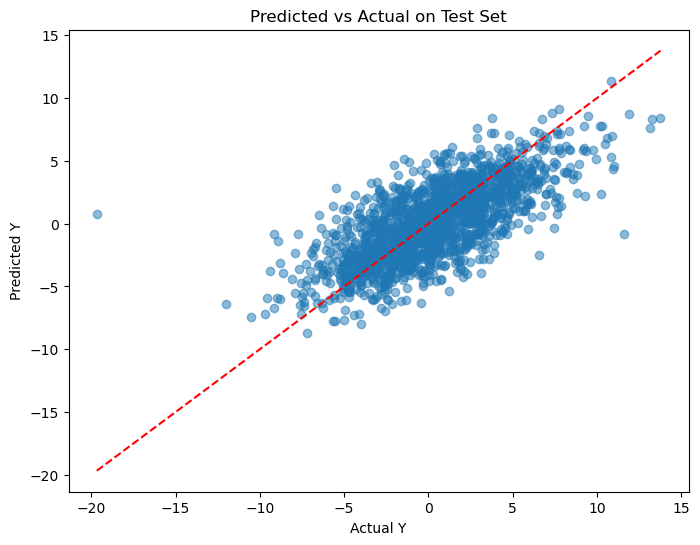

In [23]:
my_gpu_DNN.load_state_dict(torch.load('best_model_gpu.pth', weights_only=True))
# Set model to evaluation mode
my_gpu_DNN.eval()

# Predict on the test set
with torch.no_grad():
    y_pred_test = my_gpu_DNN(X_test_tensor)

# Convert predictions and true values to numpy arrays for comparison
y_pred_test = y_pred_test.squeeze().cpu().numpy()

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('Predicted vs Actual on Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [28]:
# Calculate and print test MSE
test_mse = criterion(torch.tensor(y_pred_test).squeeze(), y_test_tensor.cpu().squeeze()).item()
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 6.9140


In [19]:
print(device)

cuda:0


# end of file